# Analysis of 1/48 Deg global ocean run
Relevant links -

https://medium.com/pangeo/petabytes-of-ocean-data-part-1-nasa-ecco-data-portal-81e3c5e077be 

https://xmitgcm.readthedocs.io/en/latest/llcreader.html

https://pangeo-data.github.io/pangeo-datastore/master/ocean/llc4320.html#llc4320-grid

https://ecco.jpl.nasa.gov/products/latest/user-guide/

In [32]:
import xarray as xr
import dask.array as da
from xgcm import Grid
import xrft
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from xmitgcm import llcreader
import intake
import os
%matplotlib inline

In [33]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=4)
#cluster.adapt(minimum=1, maximum=10)

cluster

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.5.82:43337
distributed.scheduler - INFO -   dashboard at:                    :36245


In [34]:
client = Client(cluster)
client

#client.get_versions(check=True)
#client.run(lambda: os.environ)

distributed.scheduler - INFO - Receive client connection: Client-ae6340a6-2072-11ea-8169-b2891eb434b9
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.5.82:43337 Dashboard: /user/0000-0001-6559-9059/proxy/36245/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [35]:
# Load data from web
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")
dsgrid = cat["LLC4320_grid"].to_dask()

model = llcreader.ECCOPortalLLC4320Model()
ds = model.get_dataset(varnames=['U','V'], k_levels=[1]) #,k_chunksize=5)

ds = xr.merge([ds, dsgrid])
ds = ds.isel(face = 10, time = np.arange(0, 1)) #len(ds.time), 12))

print(ds)

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 1)
Coordinates:
  * k_p1     (k_p1) int64 0 1
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 1
  * k_u      (k_u) int64 1
  * k_l      (k_l) int64 1
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j,

In [36]:
# Create grid and compute vorticity, divergence
grid = Grid(ds, coords={'X': {'center': 'i', 'right': 'i_g'}, 'Y': {'center': 'j', 'right': 'j_g'}})

# Compute vorticity and divergence 
vorticity = ( - grid.diff(ds.U * ds.dxC, 'Y', boundary='fill') 
              + grid.diff(ds.V * ds.dyC, 'X', boundary='fill') ) / ds.rAz

divergence =  ( grid.diff(ds.U * ds.dxC, 'X', boundary='fill') 
              + grid.diff(ds.V * ds.dyC, 'Y', boundary='fill') ) / ds.rA

distributed.scheduler - INFO - Register tcp://10.32.2.2:35813
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.2.2:35813
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.2.3:44209
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.2.3:44209
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.12.3:45041
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.12.3:45041
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.12.2:45071
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.12.2:45071
distributed.core - INFO - Starting established connection


In [132]:
# Select data for a small region
lat1, lat2 = (35., 45.); # 10x10 deg box near gulf stream
lon1, lon2 = (-55.,-45.); # 1 deg should be avoided on each side for the final data

u1 = grid.interp(ds.U, 'X', boundary='fill')
v1 = grid.interp(ds.V, 'Y', boundary='fill')
vort = grid.interp(grid.interp(vorticity, 'X', boundary='fill'), 'Y', boundary='fill')

In [133]:
# Identify indices of lat, lon limits. I chose a fixed row/column in lats/lons to find the indices. Make sure the results do not change significantly 
idx_lat1 = (np.abs(ds.YC.isel(j=2000).values - lat1)).argmin()
idx_lat2 = (np.abs(ds.YC.isel(j=2000).values - lat2)).argmin()

idx_lon1 = (np.abs(ds.XC.isel(i=2000).values - lon1)).argmin()
idx_lon2 = (np.abs(ds.XC.isel(i=2000).values - lon2)).argmin()

In [134]:
# Extract data for the selected lat-lon domain
vort2 = vort.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})
u2 = u1.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})
v2 = v1.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})
div2 = divergence.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})
lat = ds.YC.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})
lon = ds.XC.isel({'i': slice(idx_lat2, idx_lat1), 'j' : slice(idx_lon1, idx_lon2)})

print(vort2, u2, v2, div2, lat, lon)

<xarray.DataArray 'mul-d0c2ccd28ebdf09a47c12a98756b2318' (time: 1, k: 1, j: 480, i: 679)>
dask.array<getitem, shape=(1, 1, 480, 679), dtype=float32, chunksize=(1, 1, 480, 679), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13
  * k        (k) int64 1
  * j        (j) int64 3503 3504 3505 3506 3507 ... 3978 3979 3980 3981 3982
  * i        (i) int64 2413 2414 2415 2416 2417 ... 3087 3088 3089 3090 3091 <xarray.DataArray 'mul-8028f3ae7b50d6bb89929ac294d8aa46' (time: 1, k: 1, j: 480, i: 679)>
dask.array<getitem, shape=(1, 1, 480, 679), dtype=float32, chunksize=(1, 1, 480, 679), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13
  * k        (k) int64 1
  * j        (j) int64 3503 3504 3505 3506 3507 ... 3978 3979 3980 3981 3982
  * i        (i) int64 2413 2414 2415 2416 2417 ... 3087 3088 3089 3090 3091 <xarray.DataArray 'mul-786c08eac21c72911b3a1aaeaf10accc' (time: 1, k: 1, j: 480, i: 679)>
dask.array<getitem, shape=(1, 

In [135]:
# Compute domain length/width and average grid spacings  
R = 6364.e3; # Radius of the Earth in meters

Lx = R*2*np.pi*np.cos((lat1 + lat2)*np.pi/(2*180))*np.abs(lon1-lon2)/360.
Ly = R*2*np.pi*np.abs(lat1-lat2)/360.

dx = Lx/(np.abs(idx_lon2 - idx_lon1) - 1)
dy = Ly/(np.abs(idx_lat2 - idx_lat1) - 1)

print(Lx, Ly, dx, dy)

850866.6567484337 1110727.5359691912 1776.339575675227 1638.2412034943823


# Checks 

3092 2413 3503 3983


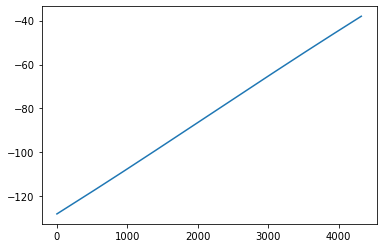

In [130]:
lats = ds.XC.isel(i=1000)
#Client.publish(lats=lats)
#print(lats.values)
#print(lats[:,0])
#print(lons[:,100])
print(idx_lat1, idx_lat2, idx_lon1, idx_lon2)
plt.plot(lats.values)

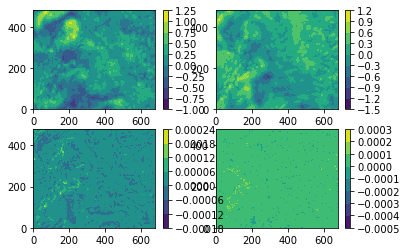

In [136]:
# Check plots of the fields

tmp_u = u2.values
tmp_v = v2.values
tmp_vort = vort2.values
tmp_div = div2.values

fig, axs = plt.subplots(2, 2)

ax = axs[0, 0]
ax1 = ax.contourf(tmp_u[0,0,:,:])
fig.colorbar(ax1, ax=ax)

ax = axs[0, 1]
ax1 = ax.contourf(tmp_v[0,0,:,:])
fig.colorbar(ax1, ax=ax)

ax = axs[1, 0]
ax1 = ax.contourf(tmp_vort[0,0,:,:])
fig.colorbar(ax1, ax=ax)

ax = axs[1, 1]
ax1 = ax.contourf(tmp_div[0,0,:,:])
fig.colorbar(ax1, ax=ax)

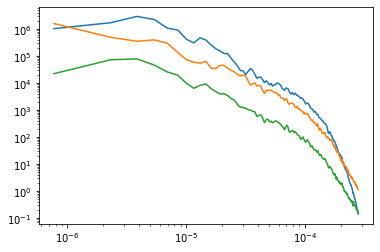

In [152]:
# Check spectrum
import spectrum as sp

spec_vort = sp.TWODimensional_spec(tmp_vort[0,0,:,0:636].squeeze(), dx, dy, detrend=True)
spec_div = sp.TWODimensional_spec(tmp_div[0,0,:,0:636].squeeze(), dx, dy, detrend=True)
spec_u = sp.TWODimensional_spec(tmp_u[0,0,:,0:636].squeeze(), dx, dy, detrend=True)

#print(spec_vort.spec.shape)
#print(spec_vort.ki)
plt.loglog(spec_vort.ki, spec_vort.ispec/spec_vort.ki**2)
plt.loglog(spec_div.ki, spec_div.ispec/spec_div.ki**2)
plt.loglog(spec_u.ki, spec_u.ispec)

#plt.contourf(tmp_vort[0,0,:,:],20,vmin=-0.001,vmax=0.001)
#plt.colorbar()
#print(tmp_vort.squeeze())

In [127]:
print(lon.values[:,0])
#ds.YC.isel(j=2000).values
#idx = (np.abs(ds.YC.isel(j=1000).values - lat2)).argmin()
#print(lat2, idx, ds.YC.isel(j=1000, i =idx).values)

[-70.010414 -69.989586 -69.96875  -69.947914 -69.927086 -69.90625
 -69.885414 -69.864586 -69.84375  -69.822914 -69.802086 -69.78125
 -69.760414 -69.739586 -69.71875  -69.697914 -69.677086 -69.65625
 -69.635414 -69.614586 -69.59375  -69.572914 -69.552086 -69.53125
 -69.510414 -69.489586 -69.46875  -69.447914 -69.427086 -69.40625
 -69.385414 -69.364586 -69.34375  -69.322914 -69.302086 -69.28125
 -69.260414 -69.239586 -69.21875  -69.197914 -69.177086 -69.15625
 -69.135414 -69.114586 -69.09375  -69.072914 -69.052086 -69.03125
 -69.010414 -68.989586 -68.96875  -68.947914 -68.927086 -68.90625
 -68.885414 -68.864586 -68.84375  -68.822914 -68.802086 -68.78125
 -68.760414 -68.739586 -68.71875  -68.697914 -68.677086 -68.65625
 -68.635414 -68.614586 -68.59375  -68.572914 -68.552086 -68.53125
 -68.510414 -68.489586 -68.46875  -68.447914 -68.427086 -68.40625
 -68.385414 -68.364586 -68.34375  -68.322914 -68.302086 -68.28125
 -68.260414 -68.239586 -68.21875  -68.197914 -68.177086 -68.15625
 -68.13541

In [52]:
u2.nbytes/1e6

1.22304

In [120]:
spec_u = np.fft.rfft2(tmp_u.squeeze())
print(spec_u)

[[nan +0.j nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 ...
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]


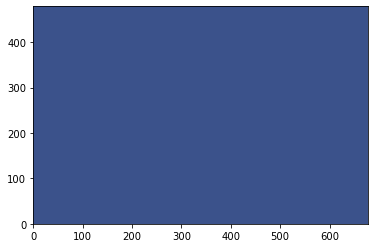

In [137]:
a = np.isnan(tmp_u.squeeze())
plt.contourf(a)

In [155]:
ds.dyC

<xarray.DataArray 'dyC' (j_g: 4320, i: 4320)>
dask.array<getitem, shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    PHrefC   float32 ...
    Z        float32 ...
    Zl       float32 ...
    Zu       float32 ...
    drF      float32 ...
    dxG      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Attributes:
    coordinate:     YG XC
    long_name:      cell y size
    standard_name:  cell_y_size_at_v_location
    units:          m